Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print (stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Exploratory Data Analysis

In [ ]:
# Load the datasets
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

In [ ]:
# Add labels to identify classes
fake_df['label'] = 'FAKE'
true_df['label'] = 'TRUE'

In [ ]:
# Merge the datasets
news = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [ ]:
# Shuffle the combined dataset
news = news.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Save the new dataset
news.to_csv('news.csv', index=False)

In [ ]:
print("Merged dataset shape:", news.shape)
print(news.head())

Merged dataset shape: (44898, 5)
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date label  
0    February 13, 2017  FAKE  
1       April 5, 2017   TRUE  
2  September 27, 2017   TRUE  
3         May 22, 2017  FAKE  
4       June 24, 2016   TRUE  


In [ ]:
# First split: Train (70%) and Temp (30%)
train_data, temp_data = train_test_split(news, test_size=0.3, random_state=42, stratify=news['label'])

In [ ]:
# Second split: Validation (15%) and Test (15%) from Temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['label'])

In [ ]:
# Save all sets
train_data.to_csv('news_train.csv', index=False)
val_data.to_csv('news_val.csv', index=False)
test_data.to_csv('news_test.csv', index=False)

print("✅ Full dataset shape:", news.shape)
print("✅ Train shape:", train_data.shape)
print("✅ Validation shape:", val_data.shape)
print("✅ Test shape:", test_data.shape)

✅ Full dataset shape: (44898, 5)
✅ Train shape: (31428, 5)
✅ Validation shape: (6735, 5)
✅ Test shape: (6735, 5)


Data Pre-processing

In [ ]:
# Check for null values in each split
print("\nNull values in Train:")
print(train_data.isnull().sum())

print("\nNull values in Validation:")
print(val_data.isnull().sum())

print("\nNull values in Test:")
print(test_data.isnull().sum())

# Save all sets
train_data.to_csv('news_train.csv', index=False)
val_data.to_csv('news_val.csv', index=False)
test_data.to_csv('news_test.csv', index=False)

print("\n Shapes -> Full:", news.shape, " Train:", train_data.shape, " Val:", val_data.shape, " Test:", test_data.shape)


Null values in Train:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Null values in Validation:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Null values in Test:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

 Shapes -> Full: (44898, 5)  Train: (31428, 5)  Val: (6735, 5)  Test: (6735, 5)


In [ ]:
train_data['content'] = train_data['title'] + ' ' + train_data['text']
val_data['content'] = val_data['title'] + ' ' + val_data['text']
test_data['content'] = test_data['title'] + ' ' + test_data['text']

In [ ]:
print(val_data['content'])

19260    “DIFFICULT” CHELSEA CLINTON CAUSES HIGH TURNOV...
27504     Melania Gives Up On Cyberbullying After Trump...
16399    Iranian general, Assad discuss joint military ...
6204     Britain will meet its Brexit financial obligat...
22111    IF OBAMA HAD A DAUGHTER: [VIDEO] #BlackLivesMa...
                               ...                        
42682     Lying Liar Behind ‘Baby Parts’ Videos Rejects...
647       The Internet Wrecks Tomi Lahren For Halloween...
26849    “BIKERS FOR TRUMP” Vow To Defend Trump During ...
39208    U.S. ELECTIONS May Already Be In Serious Jeopa...
2449     Argentina fires head of navy over submarine tr...
Name: content, Length: 6735, dtype: object


In [ ]:
print(train_data['content'])

20688    LOL! PRINCE of Country Who Gave Hillary $50 Mi...
5984     BREAKING: FLAG DRAGGING PROTESTER WHO RUSHED S...
31917     Trump’s ‘Illegal Votes’ Lie Just Turned The W...
36588    STANDING OVATION! NIGEL FARAGE TROLLS CNN Duri...
23273    New Russian ambassador to U.S. calls for resum...
                               ...                        
9433     German minister upsets fellow conservatives ov...
3460     U.S. judge rejects bid to dismiss Indonesian i...
16992    OBAMA’S GAL PAL Loretta Lynch WON’T RECUSE HER...
41610    Hungary's opposition Socialists lose PM candid...
19530     Teacher Resigns After Being Caught Knocking S...
Name: content, Length: 31428, dtype: object


In [ ]:
print(test_data['content'])

21911    MEET THE NASTY WOMEN Responsible For Promoting...
38668    WOW! Watch Side By Side Comparison Of Hillary’...
2633      Top Republican Senator BLISTERS Trump For Dem...
24188    Trump says U.S. committed to Japan security, i...
14337    Catalan separatists win election in rebuke to ...
                               ...                        
29374    Brazil's Temer to leave hospital, return to Br...
37710    GOTCHA! CNN PANELIST Called Out For Lying Abou...
19850    Compromise reached on massive U.S. defense bil...
7358     Nine killed in fighting between different bran...
11503    Italy's 5-Star sheds anti-EU image, calls for ...
Name: content, Length: 6735, dtype: object


Stremming

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
    stemmed_content = re.sub('^a-zA-Z', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [ ]:
train_data['content'] = train_data['content'].apply(stemming)
test_data['content'] = test_data['content'].apply(stemming)

In [ ]:
print(train_data['content'])

20688    lol! princ countri gave hillari $50 million be...
5984     breaking: flag drag protest rush stage trump r...
31917    trump’ ‘illeg votes’ lie turn whole recount is...
36588    stand ovation! nigel farag troll cnn cpac spee...
23273    new russian ambassador u.s. call resum militar...
                               ...                        
9433     german minist upset fellow conserv muslim holi...
3460     u.s. judg reject bid dismiss indonesian immigr...
16992    obama’ gal pal loretta lynch won’t recus crook...
41610    hungary' opposit socialist lose pm candid ahea...
19530    teacher resign caught knock special need stude...
Name: content, Length: 31428, dtype: object


In [ ]:
print(test_data['content'])

21911    meet nasti women respons promot hate intoler n...
38668    wow! watch side side comparison hillary’ lie n...
2633     top republican senat blister trump demand doj ...
24188    trump say u.s. commit japan security, chang ca...
14337    catalan separatist win elect rebuk spain eu ba...
                               ...                        
29374    brazil' temer leav hospital, return brasilia b...
37710    gotcha! cnn panelist call lie terror attack us...
19850    compromis reach massiv u.s. defens bill washin...
7358     nine kill fight differ branch somali govern fo...
11503    italy' 5-star shed anti-eu image, call reform ...
Name: content, Length: 6735, dtype: object


In [ ]:
#separating the data and label
X = train_data['content'].values
Y = train_data['label'].values

In [ ]:
print(X)

['lol! princ countri gave hillari $50 million beg american vote trump sound like one best reason ever vote trump saudi princ urg american vote donald trump upcom gener election.turki al-faisal, serv saudia arabia ambassador us 2005 2007, spoke presumpt republican nomine foreign polici dinner washington, dc thursday.h blast trump propos ban muslim enter us, billionair first formul decemb last year renew vow wednesday. life me, cannot believ countri like unit state afford someon presid simpli says, peopl go allow come unit states, turki said accord huffington post. you, me, turki added. hope you, american citizens, make right choic november. plea vote trump come surpris sinc saudi arabia donat $50 million clinton foundationwfb gulf nation repres three largest donor foundation, hardli extent tie clintons. qatari, uae, saudi firm paid bill clinton million dollar speech time hillari serv secretari state, also approv weapon deal three countri worth billion dollar u.s. defens firms, mani also

In [ ]:
print(Y)

['FAKE' 'FAKE' 'FAKE' ... 'FAKE' 'TRUE' 'FAKE']


In [ ]:
Y.shape

(31428,)

In [ ]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
counts = count_vectorizer.fit_transform(train_data['content'].values)
X = transformer.fit_transform(counts)

In [ ]:
Y = train_data['label'].values
test_counts = count_vectorizer.transform(test_data['content'].values)
test_tfidf = transformer.transform(test_counts)

In [ ]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12792461 stored elements and shape (31428, 3030288)>
  Coords	Values
  (0, 3410)	0.01893713909193526
  (0, 4075)	0.035159368862647394
  (0, 23658)	0.02969344066188877
  (0, 23667)	0.053760537731884314
  (0, 24324)	0.02989133092962238
  (0, 24609)	0.05852085112018335
  (0, 60580)	0.04638114653590592
  (0, 60862)	0.0823194062476426
  (0, 81473)	0.03549812757639657
  (0, 81489)	0.04515286244645084
  (0, 87029)	0.014517345222069492
  (0, 88064)	0.0490731468800539
  (0, 109063)	0.021483109046243516
  (0, 109480)	0.050027163662841906
  (0, 123988)	0.03740394935288842
  (0, 124006)	0.060209599169868185
  (0, 128574)	0.02605623828344473
  (0, 128847)	0.05721095636772261
  (0, 153109)	0.04261384885053431
  (0, 153316)	0.0525825628838082
  (0, 153741)	0.0490731468800539
  (0, 165546)	0.016956054836620396
  (0, 165874)	0.0490731468800539
  (0, 172990)	0.021972182264516606
  (0, 173174)	0.04825271790582307
  :	:
  (31427, 2915656)	0.022

In [ ]:
X.shape

(31428, 3030288)

In [ ]:
print(test_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2305393 stored elements and shape (6735, 3030288)>
  Coords	Values
  (0, 6807)	0.03620306084656072
  (0, 6819)	0.06168902058874092
  (0, 6859)	0.020467860049291377
  (0, 7474)	0.057923467152366355
  (0, 23410)	0.030386415610290388
  (0, 23507)	0.06168902058874092
  (0, 183002)	0.014571627740568178
  (0, 183304)	0.055720759597625555
  (0, 203456)	0.024333401803984456
  (0, 203851)	0.051117775614863865
  (0, 235958)	0.026982871550222567
  (0, 236328)	0.04489679253290388
  (0, 244759)	0.1501150482567525
  (0, 244797)	0.057923467152366355
  (0, 244826)	0.06168902058874092
  (0, 244863)	0.06168902058874092
  (0, 244883)	0.06168902058874092
  (0, 244986)	0.06168902058874092
  (0, 246206)	0.0313360393236044
  (0, 246343)	0.06168902058874092
  (0, 280051)	0.033820613595254706
  (0, 280110)	0.06168902058874092
  (0, 280189)	0.07871302445409215
  (0, 280209)	0.06168902058874092
  (0, 280233)	0.06168902058874092
  :	:
  (6734, 2884995)

In [ ]:
test_tfidf.shape

(6735, 3030288)

Splitting the data into trainind and testing data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=42)

In [ ]:
print(f"Number of Training dataset: {X_train.shape[0]}\nNumber of Testing dataset: {X_test.shape[0]}")

Number of Training dataset: 25142
Number of Testing dataset: 6286


In [ ]:
def kfolds(model, model_name):
    model = cross_val_score(model, X,Y, cv=10)
    model_score = np.average(model)
    print(f"{model_name} score on cross validation: {model_score * 100}%")

def train(model, model_name):
    model.fit(X_train, Y_train)
    model_train_score = model.score(X_train, Y_train)
    model_test_score = model.score(X_test, Y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def conf_matrix(model):
    Y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True, fmt='.2f');

def class_report(model):
    Y_pred = model.predict(X_test)
    print(classification_report(Y_test, Y_pred))

def roc(model, model_name):
    Y_pred_svm = model.decision_function(X_test)
    svm_fpr, svm_tpr, _ = roc_curve(Y_test, Y_pred_svm)
    auc_svm = auc(svm_fpr, svm_tpr)
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(svm_fpr, svm_tpr, color="darkorange", label=f'{model_name} (auc = %0.3f)' % auc_svm)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')
    plt.legend()
    plt.show()

Logistic Regression

In [ ]:
log_model = LogisticRegression()
train(log_model, "Logistic Regression")

Logistic Regression model score on Training data: 99.50680136822847%
Logistic Regression model score on Testing data: 98.52052179446389%


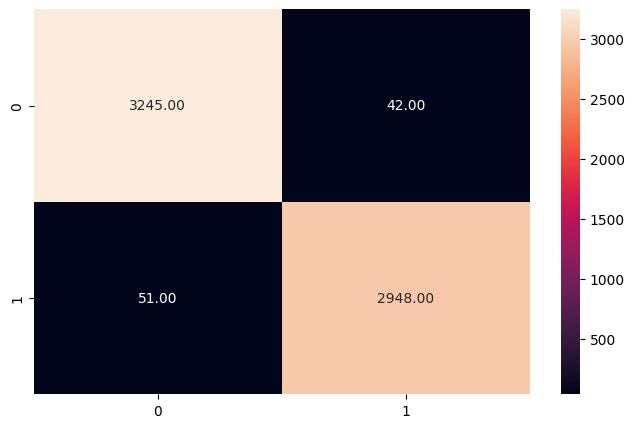

In [ ]:
conf_matrix(log_model)

In [ ]:
class_report(log_model)

              precision    recall  f1-score   support

        FAKE       0.98      0.99      0.99      3287
        TRUE       0.99      0.98      0.98      2999

    accuracy                           0.99      6286
   macro avg       0.99      0.99      0.99      6286
weighted avg       0.99      0.99      0.99      6286



In [ ]:
from sklearn.metrics import roc_curve, auc

def roc(model, model_name):
    # For models with predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        raise ValueError("Model does not support probability or decision_function")

    # Convert Y_test to binary
    y_true_binary = [1 if y == 'TRUE' else 0 for y in Y_test]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


Logistic Regression model score on Training data: 99.50680136822847%
Logistic Regression model score on Testing data: 98.52052179446389%


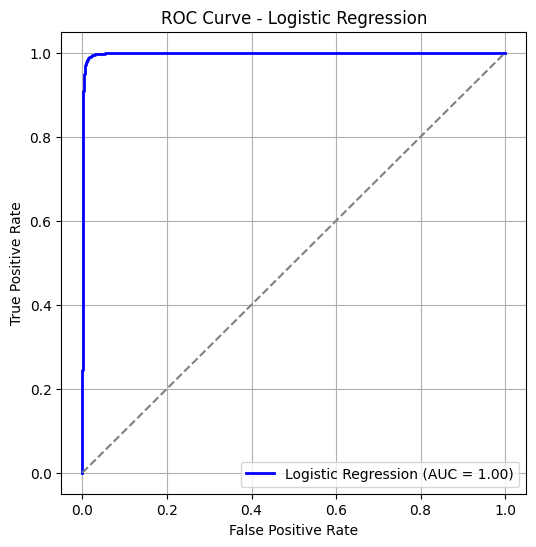

In [ ]:
log_model = LogisticRegression()
train(log_model, "Logistic Regression")
roc(log_model, "Logistic Regression")

SVM Model

In [ ]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
train(svm_model, "Linear SVM")

Linear SVM model score on Training data: 100.0%
Linear SVM model score on Testing data: 99.68183264397072%


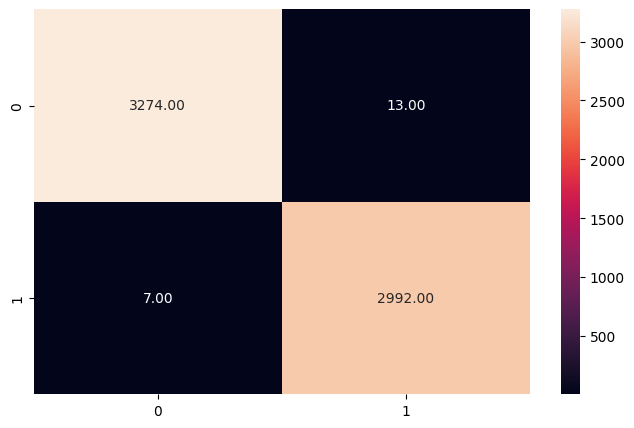

In [ ]:
conf_matrix(svm_model)

In [ ]:
class_report(svm_model)

              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      3287
        TRUE       1.00      1.00      1.00      2999

    accuracy                           1.00      6286
   macro avg       1.00      1.00      1.00      6286
weighted avg       1.00      1.00      1.00      6286



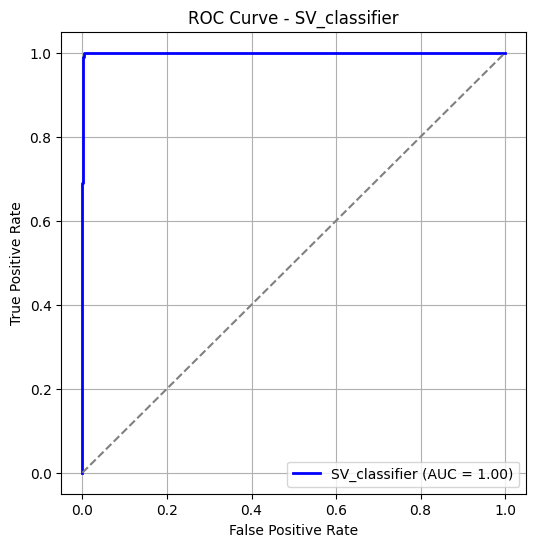

In [ ]:
roc(svm_model, 'SV_classifier')

Decision tree classifier Model

In [ ]:
dt_model = DecisionTreeClassifier()
kfolds(dt_model, "Decision_Tree")
train(dt_model, "Decision_Tree")

Decision_Tree score on cross validation: 99.72317617297126%
Decision_Tree model score on Training data: 100.0%
Decision_Tree model score on Testing data: 99.76137448297806%


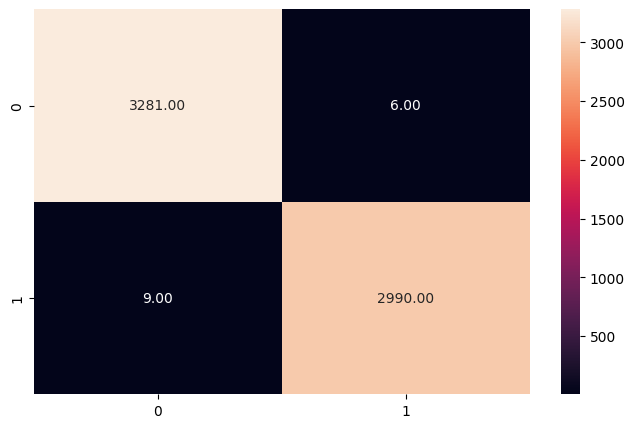

In [ ]:
conf_matrix(dt_model)

In [ ]:
class_report(dt_model)

              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      3287
        TRUE       1.00      1.00      1.00      2999

    accuracy                           1.00      6286
   macro avg       1.00      1.00      1.00      6286
weighted avg       1.00      1.00      1.00      6286



Random forest classifier

In [ ]:
rf_model = RandomForestClassifier()
train(rf_model, "Random_Forest")

Random_Forest model score on Training data: 100.0%
Random_Forest model score on Testing data: 98.48870505886096%


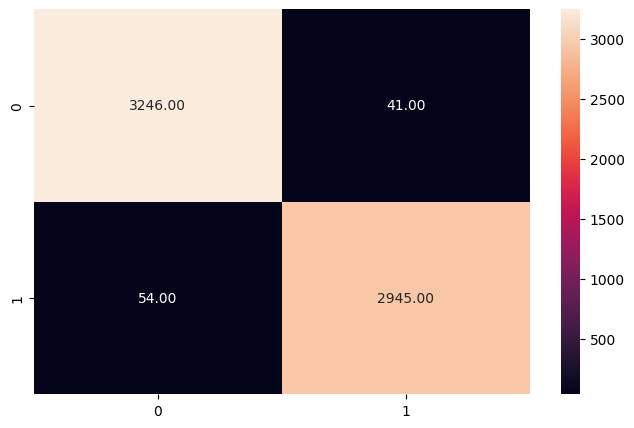

In [ ]:
conf_matrix(rf_model)

In [ ]:
class_report(rf_model)

              precision    recall  f1-score   support

        FAKE       0.98      0.99      0.99      3287
        TRUE       0.99      0.98      0.98      2999

    accuracy                           0.98      6286
   macro avg       0.98      0.98      0.98      6286
weighted avg       0.98      0.98      0.98      6286



K-nearest neighbors

In [ ]:
knn = KNeighborsClassifier()
train(knn, "KNN")

KNN model score on Training data: 92.23212154959828%
KNN model score on Testing data: 88.62551702195354%


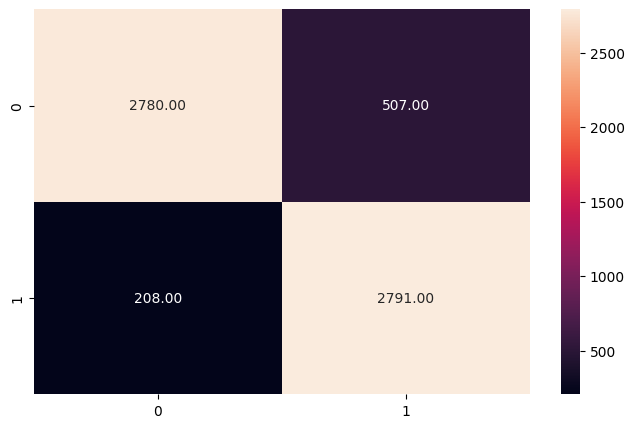

In [ ]:
conf_matrix(knn)

In [ ]:
class_report(knn)

              precision    recall  f1-score   support

        FAKE       0.93      0.85      0.89      3287
        TRUE       0.85      0.93      0.89      2999

    accuracy                           0.89      6286
   macro avg       0.89      0.89      0.89      6286
weighted avg       0.89      0.89      0.89      6286



Naive Bayes

In [ ]:
naive_bayes = MultinomialNB()
kfolds(naive_bayes, "Naive_Bayes")
train(naive_bayes, "Naive_Bayes")

Naive_Bayes score on cross validation: 96.39174624057219%
Naive_Bayes model score on Training data: 98.22607588895076%
Naive_Bayes model score on Testing data: 96.08654152083996%


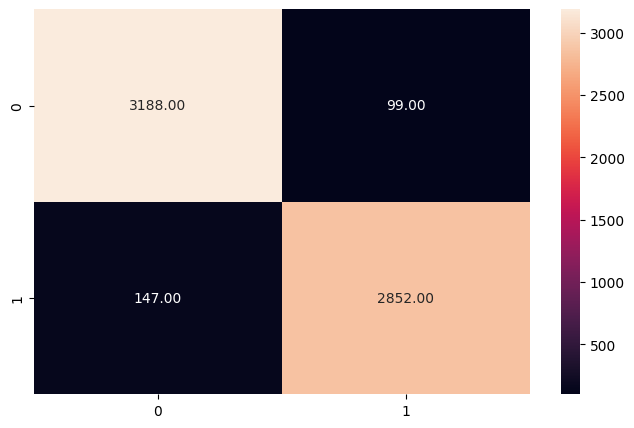

In [ ]:
conf_matrix(naive_bayes)

In [ ]:
class_report(naive_bayes)

              precision    recall  f1-score   support

        FAKE       0.96      0.97      0.96      3287
        TRUE       0.97      0.95      0.96      2999

    accuracy                           0.96      6286
   macro avg       0.96      0.96      0.96      6286
weighted avg       0.96      0.96      0.96      6286

